In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import digamma
%matplotlib inline
from ct_charachterization.utility.utils import central_gamma_pdf
from glob import glob
import pydicom as dicom
import dicom_numpy
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.stats import mode
import matplotlib.patches as patches
from ct_charachterization import run_third_algorithm_gamma_instead_of_pi, run_third_algorithm_expectation_at_the_end, run_third_algorithm_expectation_at_the_beginning, run_linear_combination_of_components
from ct_charachterization.utility.utils import expand, contract
from copy import deepcopy

# Global estimate

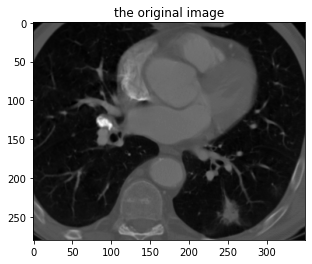

In [2]:
luna = np.load(f'../resources/luna_cropped.npy')

plt.imshow(luna, cmap='gray')
plt.title("the original image")
plt.show()

The image is bigger than what my mac can afford to calculate the whole process. 
So, I crop the image to be in (128,128) shape. The size of each neighborhood will be 32/*32. Then, 16 voxels from each side of the cropped image will be inside the other's neighborhood, but they will not be considered as the center of any neighborhood.

So, we are going on with insider part of the red rectangle.

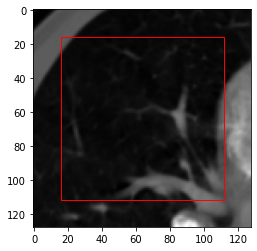

In [3]:
import matplotlib.patches as patches
y = luna[:128,:128]
fig1, ax1 = plt.subplots(1)
ax1.imshow(y, cmap='gray')
rect = patches.Rectangle((16,16),96,96,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.show()

In [4]:
from ct_charachterization import run_first_algorithm
mu_9 = np.array([-900, -760, -370, -160, 0, 100, 240, 340])
global_theta, global_gamma = run_first_algorithm(y=deepcopy(y[16:128-16, 16:128-16]), mu=mu_9+1130, 
                                                 neighborhood_size=0, delta=-1130, max_iter=10,
                                                 tol=0.00000001, non_central=False)

iteration: 1, error: 0.0005929937490175491
iteration: 2, error: 0.0


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:43: RuntimeWarning: invalid value encountered in log
  blocked_log_y = block_matrix(mat=np.log(y), neighborhood_shape=shape_of_each_neighborhood)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(8, 1, 1)
-915 -1930
-845 -1790
-650 -1400
-545 -1190
-465 -1030
-415 -930
-345 -790
-295 -690


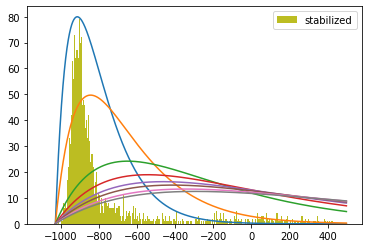

In [5]:
global_alpha = global_theta[1, ...]
global_beta = global_theta[2, ...]
delta = -1030
print(global_alpha.shape)
for j in range(len(mu_9)):
    wanted_alpha = global_alpha[j,...]
    wanted_beta = global_beta[j,...]
    xs = np.arange(-1030, 500, 1) - delta 
    ys = 25000 * central_gamma_pdf(xs, wanted_alpha, wanted_beta).ravel()
    plt.plot(xs + delta, ys, '-')
    print(xs[np.argmax(ys)] + delta, mu_9[j] + delta)
flat1 = deepcopy(y[16:128-16, 16:128-16]).flatten()
plt.hist(flat1, bins=list(np.arange(-1100, 500, 1)), label='stabilized')
plt.legend(loc='upper right')
plt.show()

Now, we want to make sure that pi values are correct.
If we consider each component as a basis, weighted sum of components (wieght values are pi or probabilities) should look like the original image. 
So, each voxel value will be the linear combination of component values. (attenuation levels)

-915 -1930


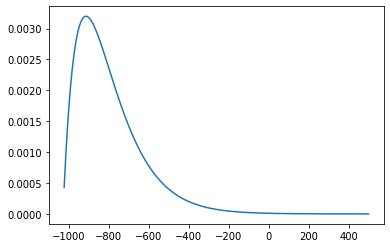

-845 -1790


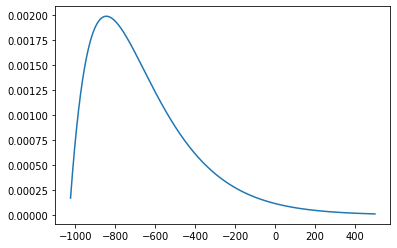

-650 -1400


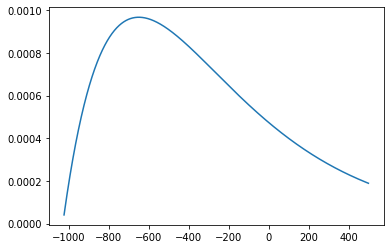

-545 -1190


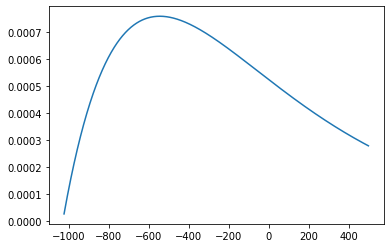

-465 -1030


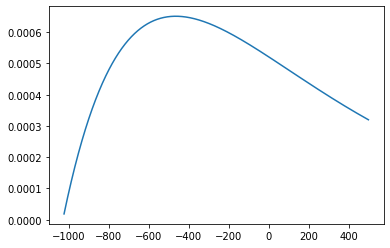

-415 -930


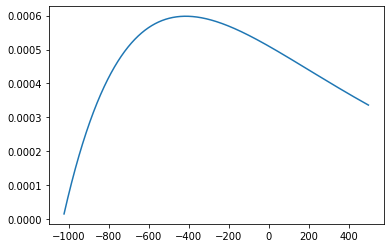

-345 -790


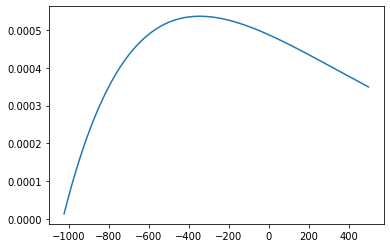

-295 -690


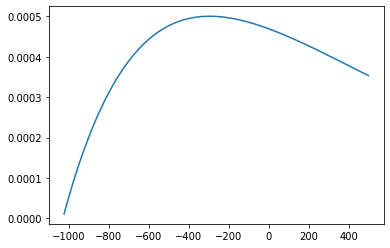

In [6]:
for j in range(len(mu_9)):
    wanted_alpha = global_alpha[j]
    wanted_beta = global_beta[j]
    xs = np.arange(-1024, 500, 1) + 1030
    ys = central_gamma_pdf(xs, wanted_alpha, wanted_beta).ravel()
    plt.plot(xs - 1030, ys, '-')
    print(xs[np.argmax(ys)] -1030, mu_9[j] - 1030)
    plt.show()

/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:10: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


iteration: 1, error: 0.22746936571783433
iteration: 2, error: 2.6609204761973097e-16


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_first_algorithm.py:91: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  theta_before_expansion = np.array([initial_pi, initial_alpha, initial_beta])


iteration: 1, error: 0.30871484647041003
iteration: 2, error: 0.0037424840134966573


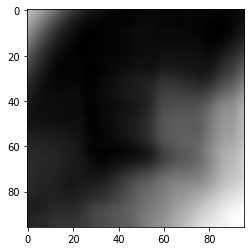

In [7]:
lc = run_linear_combination_of_components(y, mu_9, non_central=True, neighborhood_size=32, max_iter=5)
plt.imshow(lc, cmap='gray')
plt.show()

# Variance stabilization

To use the vectorization of NumPy, I have made a function: `expand`. (This is in replace of copying a part of the image -- a single neighborhood -- each time and it may increase the ram usage but reduces the execution time.)
The image below shows the functionality of `expand`. (selects some number of center voxels and copies all its neighborhoods into a bigger matrix)

![expand](../resources/figs/expand.png)

OK, let's continue.

![expand](../resources/figs/beg.png)

iteration: 1, error: 0.24464733480711032
iteration: 2, error: 5.770525655106214e-17
iteration: 1, error: 0.40102296277486066


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/utility/utils.py:73: RuntimeWarning: overflow encountered in power
  def central_gamma_pdf(y, alpha, beta):
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/utility/utils.py:74: RuntimeWarning: overflow encountered in multiply
  assert (alpha > 0).all() and (
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/utility/utils.py:73: RuntimeWarning: invalid value encountered in multiply
  def central_gamma_pdf(y, alpha, beta):


iteration: 2, error: 0.0003645045249466473


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:121: RuntimeWarning: invalid value encountered in true_divide
  first_local_sample_conditioned_moment[j, ...] = first_numerator_summation / denominator_summation
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:122: RuntimeWarning: invalid value encountered in true_divide
  second_local_sample_conditioned_moment[j, ...] = second_numerator_summation / denominator_summation


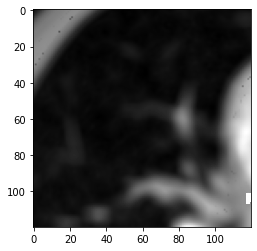

In [14]:
mu_9 = np.array([-987, -810, -540, -370, -160, 0, 100, 240, 340])

resul = run_third_algorithm_expectation_at_the_beginning(y, mu_9, non_central=True, constant_c=10, neighborhood_size=8, max_iter=5)
plt.imshow(resul, cmap='gray')
plt.show()

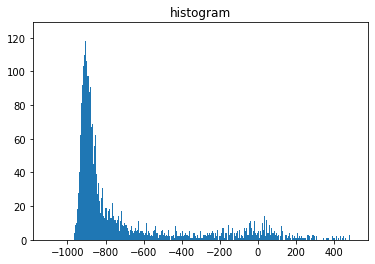

min: nan, mean: nan, max: nan


In [15]:
flat = resul.flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')

![expand](../resources/figs/end.png)

iteration: 1, error: 0.24464733480711032
iteration: 2, error: 5.770525655106214e-17
iteration: 1, error: 0.40102296277486066
iteration: 2, error: 0.0003645045249466473


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:86: RuntimeWarning: invalid value encountered in sqrt
  first_local_sample_conditioned_moment[j, ...]) / np.sqrt(
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:84: RuntimeWarning: divide by zero encountered in true_divide
  y_stab[j, ...] = (constant_c * (np.sqrt(y[half_neigh:first_shape - half_neigh,
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:80: RuntimeWarning: invalid value encountered in true_divide
  first_local_sample_conditioned_moment[j, ...] = first_numerator_summation / denominator_summation
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:81: RuntimeWarning: invalid value encountered in true_divide
  second_local_sample_conditioned_moment[j, ...] = second_numerator_summation / denominator_summation


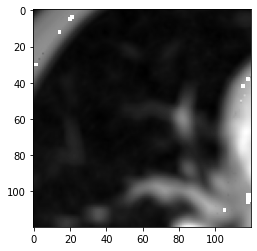

In [16]:
resul = run_third_algorithm_expectation_at_the_end(y, mu_9, non_central=True, constant_c=10, neighborhood_size=8, max_iter=5)
plt.imshow(resul, cmap='gray')
plt.show()

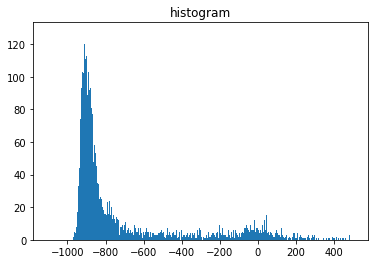

min: nan, mean: nan, max: nan


In [18]:
flat = resul.flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')

![expand](../resources/figs/gam_pi.png)

iteration: 1, error: 0.24464733480711032
iteration: 2, error: 5.770525655106214e-17
iteration: 1, error: 0.40102296277486066
iteration: 2, error: 0.0003645045249466473


/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:38: RuntimeWarning: invalid value encountered in true_divide
  first_local_sample_conditioned_moment[..., j] = np.nan_to_num(first_numerator_summation / denominator_summation)
/Users/mostafa/PycharmProjects/ncg/ct_charachterization/_third_algorithm.py:40: RuntimeWarning: invalid value encountered in true_divide
  second_numerator_summation / denominator_summation)


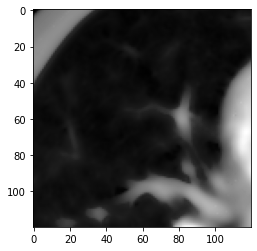

In [19]:
resul = run_third_algorithm_gamma_instead_of_pi(y, mu_9, non_central=True, constant_c=10, neighborhood_size=8, max_iter=5)
plt.imshow(resul, cmap='gray')
plt.show()

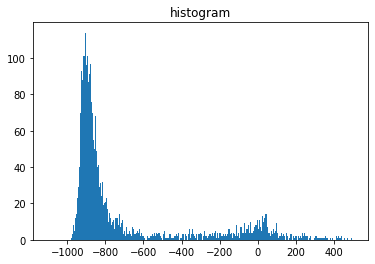

min: -990.6483558004246, mean: -670.623494599297, max: 868.9607817283493


In [20]:
flat = resul.flatten() - 1030
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("histogram")
plt.show()
print(f'min: {np.min(flat)}, mean: {np.mean(flat)}, max: {np.max(flat)}')